# Pre-process

### Import libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.version

'3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]'

### Load sources

In [3]:
data_dict = {}
years = [2020, 2021, 2022, 2023]
base = './data/'

def get_df(_year):
    diff_year = 2022
    # Avoid inconsitences in headers
    date_field = 'Fecha' if year == diff_year else 'fecha'
    
    df = pd.read_csv(f'{base}/linea144-{year}.csv', parse_dates=[date_field])
    if year == diff_year:
        df = df.rename(columns={'Fecha': 'fecha'})

    return df


for year in years:    
    # Read file
    data_dict[year] = get_df(year)
            
# Concat dataframes
data = pd.concat(data_dict, ignore_index=True)

# Excluding last column with no data
data = data.iloc[:,:-1]

assert data.shape == (84861, 19), display(data.sample(10), data.shape)
assert data.fecha.dtype == 'datetime64[ns]', "'fecha' must be a datetime64 type"

print('Data loaded ...')

Data loaded ...


### Filling missing values (categorical) 

**Summary from the article**

So the first step is to see if your data has missing values. If your data has missing values, you need to check the distribution of each numerical variable (with missing values). If the values in the numerical variables are missing, use the Mean value if the variable is in a normal distribution. Otherwise, choose Median. And if the variable is categorical or discrete, you can select mode. So you need to choose a different measure for each variable. I hope you liked this article on how to fill in missing values in your data. Feel free to ask valuable questions in the comments section below. [More...](https://thecleverprogrammer.com/2023/03/14/heres-how-to-fill-in-missing-values-in-a-dataset/)

In [4]:
# Filling nan rows with mode
def fill_with_mode_the_nan_values(field):
    try:
      # n records NaN to theis field 
      fields_nan = data[field].isna().sum()
            
      if fields_nan > 0:
          # filling using the mode, like shown in link above
          field_mode = data[field].mode()[0]

          data[field].fillna(field_mode, inplace=True)
      return field, fields_nan
    except Exception as e:
       return e
       
fields = ['prov_residencia_persona_en_situacion_violencia', 'genero_persona_en_situacion_de_violencia', \
          'pais_nacimiento_persona_en_situacion_de_violencia', 'vinculo_con_la_persona_agresora', \
            'genero_de_la_persona_agresora']

[fill_with_mode_the_nan_values(field) for field in fields]

assert data.fecha.dtype == 'datetime64[ns]', "'fecha' must be a datetime64 type"



### Filling numeric values (edad_persona_en_situacion_de_violencia) using the median
* **Mean**, when we have a normal distribution
* **Median**, otherwise

Kurtosis: 1.315091416195283
There are/was 16402 missing values to field "edad_persona_en_situacion_de_violencia"


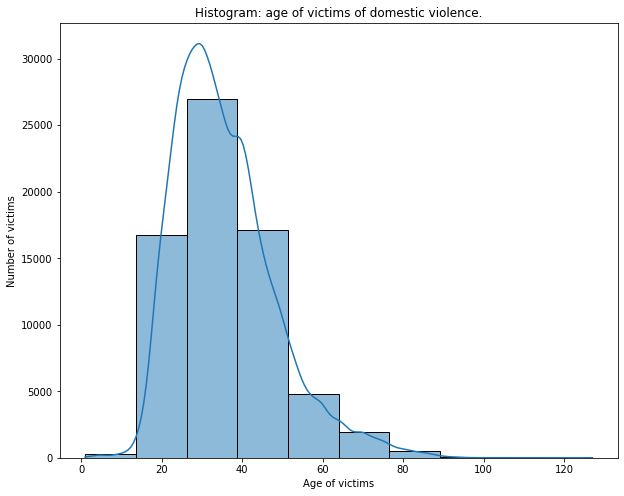

In [5]:
# Histogram: distribution ins't normal

# Calculate kurtosis
print(f'Kurtosis: {data.edad_persona_en_situacion_de_violencia.kurtosis()}')

# Count of missing values
print(f'There are/was {data.edad_persona_en_situacion_de_violencia.isna().sum()} missing values to field "edad_persona_en_situacion_de_violencia"')

plt.figure(figsize=(10, 8))
f = sns.histplot(data['edad_persona_en_situacion_de_violencia'], bins=10, kde=True)
f.set_title('Histogram: age of victims of domestic violence.')
f.set_xlabel("Age of victims")
f.set_ylabel("Number of victims")
plt.show()

# Calculate the median
age_median = data.edad_persona_en_situacion_de_violencia.median()

# Filling data with the mean
data.edad_persona_en_situacion_de_violencia.fillna(age_median, inplace=True)

assert data.fecha.dtype == 'datetime64[ns]', f"'fecha' must be a datetime64 type, but is {data.fecha.dtype}"

### Updating types and modalities whose values are boolean

In [6]:
# 1. Define wich fields will be processed 
boolean_fields = ['tipo_de_violencia_fisica', 'tipo_de_violencia_psicologica', 'tipo_de_violencia_sexual', \
                    'tipo_de_violencia_economica_y_patrimonial', 'tipo_de_violencia_simbolica', 'tipo_de_violencia_domestica',
                    'modalidad_de_violencia_institucional', 'modalidad_de_violencia_laboral', \
                    'modalidad_violencia_contra_libertad_reproductiva', 'modalidad_de_violencia_obstetrica', \
                    'modalidad_de_violencia_mediatica', 'modalidad_de_violencia_otras']


# 2. View and confirmation that they are boolean
def fields_view_validation(field):
    print(f"Types for field '{field}': {data[field].unique()}")

# 3. Show
[fields_view_validation(field) for field in boolean_fields]

# 4. Cast to boolean 
mapping = {'Si': True, 'SI': True, 'No': False, 'NO': False} 
for field in boolean_fields:
    data[field] = data[field].map(mapping)

# 5. Unify "duplicate" province
data['prov_residencia_persona_en_situacion_violencia'] = data['prov_residencia_persona_en_situacion_violencia'] \
    .apply(lambda x : 'Santiago Del Estero' if x == 'Santiago del Estero' else x)

data['prov_residencia_persona_en_situacion_violencia'] = data['prov_residencia_persona_en_situacion_violencia'] \
    .apply(lambda x : 'Córdoba' if x == 'Cordoba' else x)

Types for field 'tipo_de_violencia_fisica': ['Si' 'No']
Types for field 'tipo_de_violencia_psicologica': ['Si' 'No']
Types for field 'tipo_de_violencia_sexual': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_economica_y_patrimonial': ['No' 'Si']
Types for field 'tipo_de_violencia_simbolica': ['No' 'Si' 'SI']
Types for field 'tipo_de_violencia_domestica': ['Si' 'No']
Types for field 'modalidad_de_violencia_institucional': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_laboral': ['No' 'Si' 'SI']
Types for field 'modalidad_violencia_contra_libertad_reproductiva': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_obstetrica': ['No' 'Si' 'SI']
Types for field 'modalidad_de_violencia_mediatica': ['No' 'Si']
Types for field 'modalidad_de_violencia_otras': ['No' 'Si']


### Saving to parquet

In [7]:
data.to_parquet('./data/linea_144_processed.parquet')